# PPS Domain Scoring Classifier - V2
# Recap from V1

## The problem 
For a large number of images, each one has usage(s) associated with it, and those usages each have a domain. Some of the domains are valuable (~2-10%), and the vast majority are not (this is an imbalanced class problem). The current implementation is a rules based algorithm to determine what domains are worth pursuing. 

## V1 steps towards finding a solution
Version 1 started the process of figuring out how to build a machine learning classifier to replace the rules based algorithm that decides which domains are worth pursuing. V1 delved into some of the statistical analysis regarding what input features to pursue and why. It also looked at different data sets in order to determine the best way to create a good number of positive and negative examples. 

## Feature Selection:
After all of the analysis in version 1, the following input features were selected due to statistical significance:

## Input Features:
> 
* **`trafficDataRank`**: float
* **`privateRegistrationStatus`**: Boolean
* **`domainAge`**: float
* **`registrantContactCountry`**: String (USA, Canada, etc) 

## Output Classifier
> * **`analystResult`:** Boolean (1/0)

## Data
The actual data used is compiled from two test files:
> 1. **`PPSdomains.csv`**
2. **`allDomains.csv`**
  
## `PPSdomains.csv`
This file is comprised of **2147** training examples where an analyst went through and either gave the training example a **`analystResult`** of:
> * 1: worth pursuing, a total of 1375 examples
* 0: not worth pursuing, a total of 756 examples

Several things are worth noting- this is an imbalanced class problem. In the real world, only 2-10% of domains will be considered valuable. However, our data is skewed at a nearly 2:1 ratio in the other direction: we have many more negative examples compared to positive examples. 

## `allDomains.csv`
This file is comprised of **78325** training examples-however, there is no official **`analystResult`** given, hence these examples are not officially labeled. However, in an effort to gather more negative examples, this file has a features **`BellonaStatus`** that is considered to be very similar to the **`analystResult`** score. 

`BellonaStatus` then had to be mapped to `analystResult`. 

## Model 
During the creation of models and training process, a handful of classifiers were picked through, and the most effective by far was a **Random Forest**. That is the model I am going to use going forward. 

## Training/Testing Validation
One thing that I specifically want to do in **V2** is create not only a training and testing data set, but also a cross validation one to prevent over tuning the hyperparameters to the test set. 

This test set will only be used at the very end to get an idea of how the model performs in the real world. 


## Training/Testing Validation Sizes
I decided to use the following for my training, validation, and testing size: 60/20/20.

## Scoring
I want to give a brief overview of how I am going to be scoring model performance in V2. In order to do so, I want to provide a brief overview of the metrics I am going to be using. 


Let's start by looking at a **confusion matrix** that hold all possible outcomes of our prediction compared to the actual value. 

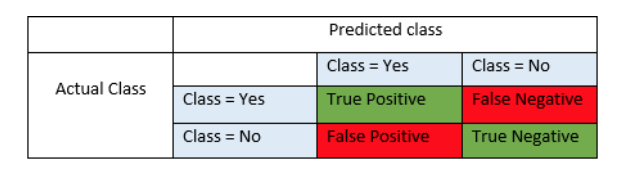

True positive and true negatives are the observations that are correctly predicted and therefore shown in green. We want to minimize false positives and false negatives so they are shown in red color. These terms are a bit confusing. So let’s take each term one by one and understand it fully.

**True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. E.g. if actual class value indicates that domains is valuable and predicted class tells you the same thing.

**True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this domain is not valuable and predicted class tells you the same thing.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

**False Positives (FP)** – When actual class is no and predicted class is yes. E.g. if actual class says this domain is not valuable but predicted class tells you that domain is valuable. Note, this is also refered to as **Type I error**.

**False Negatives (FN)** – When actual class is yes but predicted class in no. E.g. if actual class value indicates that this domain is valuable and predicted class tells you that domain is not valuable. Note, this is also refered to as **Type II error**.

Once you understand these four parameters then we can calculate Accuracy, Precision, Recall and F1 score.

### Accuracy
Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model.

### $$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$$

### Precision 
"How often does the algorithm cause a false alarm?". Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all domains that our model labeled as worth pursuing, how many actually were worth pursuing? 

### $$Precision = \frac{TP}{TP+FP}$$

### Recall
"How sensitive is our algorithm?". Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the domains that were actually marked as worth pursuing, how many did the model classify as worth pursuing? 

### $$Recall = \frac{TP}{TP+FN}$$

### F1 Score
F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.er

### $$F1 = \frac{2*(Recall * Precision)}{(Recall + Precision)}$$

Okay, so with that background taken care of, I am going to be building out this model with the goal of maximizing accuracy and precision above all else. Because all the classifier needs to do to get 90% accuracy in the real world is predict `not worth pursuing` everytime, we cannot try to optimize around that metric. 

With that said I am going to create a method to import, preprocess, and concatenate all of our data as needed. All the steps and reasoning for each line of code can be seen in V1. 

In [2]:
# standard
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def preprocessScoredDomains(): 
    # --------- analyst scored domains -------------
    domains = pd.read_csv('PPSDomains.csv')
    
    # getting rid of unscored examples
    domains = domains[pd.notnull(domains['analystResult'])] 
    
    # dropping features that will not be used
    domains = domains.drop(['historyDataScore', 'medianLoadTime','speedPercentile', 'trafficDataReachRank', 
                            'reachPerMillionValue', 'pageViewsRankValue','pageViewsPerMillionValue', 
                            'usageStatisticRankValue', 'reachRankValue', 'BellonaStatus', ], axis=1)
    
    # map analystResult to boolean
    ar = {'TRUE': 1, 'FALSE': 0, 'TRUE ': 1, 'FALSE ': 0}
    domains['analystResult'] = domains['analystResult'].map(ar)
    
    # mapping privateRegistrationStatus to boolean
    domains['privateRegistrationStatus'] = domains['privateRegistrationStatus'].replace(np.nan, 0)
    domains['privateRegistrationStatus'] = domains['privateRegistrationStatus'].map(lambda x: 1 if x != 0 else 0)
    
    # imputing data
    domains['domainAge'] = domains['domainAge'].fillna(domains['domainAge'].mean())
    domains['trafficDataRank'] = domains['trafficDataRank'].replace(np.nan, domains['trafficDataRank'].mean())
    
    # normalizing floats
    domains['trafficDataRank'] = (domains['trafficDataRank'] - domains['trafficDataRank'].mean())/(domains['trafficDataRank'].std())
    domains['domainAge'] = (domains['domainAge'] - domains['domainAge'].mean())/(domains['domainAge'].std())
    
    # One hot encoding registrantContactCountry
    countries = domains.registrantContactCountry.unique()
    domains = pd.get_dummies(domains, columns=["registrantContactCountry"], prefix=["Country"])
    
    return domains, countries

domains, countries = preprocessScoredDomains()

In [4]:
def preprocessingBellonaStatusDomains():
    # --------- megaDomains - scored with BellonaStatus -------------
    megaDomains = pd.read_csv('allDomains.csv')
    
    # dropping features that will not be used
    megaDomains = megaDomains.drop(['historyDataScore','medianLoadTime','speedPercentile', 
                                    'trafficDataReachRank', 'reachPerMillionValue', 'pageViewsRankValue', 
                                    'pageViewsPerMillionValue', 'usageStatisticRankValue', 
                                    'reachRankValue' ], axis=1)
    
    # convert BellonaStatus to analystResult
    megaDomains = megaDomains.rename(index=str, columns={"BellonaStatus": "analystResult"})
    megaDomains = megaDomains.rename(index=str, columns={"domains": "domain"})
    
    # get negative examples
    ar = {'SKIP_FOREIGN': 0, 'SKIP_WORTHLESS': 0, 'SKIP_FAKEDATA': 0, 'SKIP_DMCA': 0, 
          'HOLD_PRIVATE_REGISTRATION': 0, 'SKIP_HYPERLINKING': 0, 'SKIP_CDL_CLIENT': 0,
          'SKIP_MALWARE': 0,'SKIP_OFFLINE': 0 }
    megaDomains['analystResult'] = megaDomains['analystResult'].map(ar)
    megaDomains = megaDomains[megaDomains['analystResult'] == 0]
    
    # impute data
    megaDomains['trafficDataRank'] = megaDomains['trafficDataRank'].replace(np.nan, megaDomains['trafficDataRank'].mean())
    megaDomains['domainAge'] = megaDomains['domainAge'].replace(np.nan, megaDomains['domainAge'].mean())
    
    # normalize floats
    megaDomains['trafficDataRank'] = (megaDomains['trafficDataRank'] - megaDomains['trafficDataRank'].mean())/(megaDomains['trafficDataRank'].std())
    megaDomains['domainAge'] = (megaDomains['domainAge'] - megaDomains['domainAge'].mean())/(megaDomains['domainAge'].std())
    
    # mapping privateRegistrationStatus to boolean
    megaDomains['privateRegistrationStatus'] = megaDomains['privateRegistrationStatus'].replace(np.nan, 0)
    megaDomains['privateRegistrationStatus'] = megaDomains['privateRegistrationStatus'].map(lambda x: 1 if x != 0 else 0)
    
    # One hot encoding registrantContactCountry
    megaDomains['registrantContactCountry'] = megaDomains['registrantContactCountry'].replace(np.nan, "UNKNOWN")
    megaDomains = megaDomains[megaDomains['registrantContactCountry'].isin(countries)]
    megaDomains = pd.get_dummies(megaDomains, columns=["registrantContactCountry"], prefix=["Country"])
    
    return megaDomains

megaDomains = preprocessingBellonaStatusDomains()

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
domains.shape

(2147, 15)

# Creating Test Set
* This is our test set - we will lock this away at the start of tuning and not use it until the end in order to get an accurate result of final model performance.
* it will have 10% of the initial positive examples, ~ 140 in total
* It will have 771 negative examples

In [6]:
# positive_test_examples = domains[domains['analystResult'] == 1].sample(frac=0.1, replace=False)
# domains = domains.drop(positive_test_examples.index)

# negative_test_examples = domains[domains['analystResult'] == 0]
# domains = domains.drop(negative_test_examples.index)

# test_examples = pd.concat([positive_test_examples, negative_test_examples])

# Creating Training and Cross Validation Set
* At this point domains has no more negative examples
* All analyst scored domains that were marked as negative are going to be used for final testing
* the negative examples are going to be taken from a mapping of BellonaStatus to analystResult in megaDomains

I am going to take the 1238 positive examples from domains, and concatenate them together with 1238 negative random samples from megaDomains.

In [7]:
# number_positive_examples = domains.shape[0]
# megaDomains = megaDomains.iloc[np.random.randint(0, len(megaDomains), number_positive_examples)]

# combinedDomains = pd.concat([domains, megaDomains])

## Now time to create the actual training and CV set

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# X = combinedDomains.drop(['domain', 'analystResult'], axis=1)
# y = combinedDomains['analystResult']

# X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=101)
domains = shuffle(domains)

In [10]:
train, validate, test = np.split(domains.sample(frac=1), [int(.6*len(domains)), int(.8*len(domains))])
X_train = train.drop(['domain', 'analystResult'], axis=1)
y_train = train['analystResult']

X_validate = validate.drop(['domain', 'analystResult'], axis=1)
y_validate = validate['analystResult']

X_test = test.drop(['domain', 'analystResult'], axis=1)
y_test = test['analystResult']

# Train our Model
* We are going to be using a Random Forest!

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
X_train.head()

,trafficDataRank,domainAge,privateRegistrationStatus,Country_AUSTRALIA,Country_CANADA,Country_FRANCE,Country_GERMANY,Country_ITALY,Country_NETHERLANDS,Country_SINGAPORE,Country_UK,Country_UNITED KINGDOM,Country_UNITED STATES
716,0.00000,-1.291888,1,0,0,0,0,0,0,0,0,0,1
1682,0.00000,-0.742226,1,0,0,0,0,0,0,0,0,0,1
1125,0.00000,-1.276203,0,0,0,0,0,0,0,0,0,0,1
1998,-0.79578,0.180384,0,0,0,0,0,0,0,0,0,0,1
903,0.00000,0.914429,1,0,0,0,0,0,0,0,0,0,1


In [13]:
X_test.head()

,trafficDataRank,domainAge,privateRegistrationStatus,Country_AUSTRALIA,Country_CANADA,Country_FRANCE,Country_GERMANY,Country_ITALY,Country_NETHERLANDS,Country_SINGAPORE,Country_UK,Country_UNITED KINGDOM,Country_UNITED STATES
2120,-0.785843,0.975774,0,0,0,0,0,0,0,0,0,0,1
1602,-0.750271,0.601432,1,0,0,0,0,0,0,0,0,0,1
1768,0.000000,-0.221842,1,0,0,0,0,0,0,0,0,0,1
667,0.000000,0.105098,0,0,0,0,0,0,0,0,0,0,1
1630,0.000000,-1.241000,1,0,0,1,0,0,0,0,0,0,0


In [137]:
clf = RandomForestClassifier(max_depth=5, random_state=20, class_weight={0: 2, 1: 1.5})
clf.fit(X_train, y_train)
validate_predictions = clf.predict(X_validate)

In [138]:
cm = confusion_matrix(y_validate, validate_predictions, labels=[1, 0])
cm

array([[243,  30],
       [127,  29]])

In [139]:
accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
accuracy

0.63403263403263399

In [140]:
precision = cm[0,0]/(cm[0,0]+cm[1,0])
precision

0.65675675675675671

In [141]:
test_predictions = clf.predict(X_test)

In [142]:
cm2 = confusion_matrix(y_test, test_predictions, labels=[1, 0])
cm2

array([[237,  48],
       [117,  28]])

In [143]:
accuracy = (cm2[0,0]+cm2[1,1])/(cm2[0,0]+cm2[0,1]+cm2[1,0]+cm2[1,1])
accuracy

0.61627906976744184

In [144]:
precision = cm2[0,0]/(cm2[0,0]+cm2[1,0])
precision

0.66949152542372881

In [145]:
training_predictions = clf.predict(X_train)
cm = confusion_matrix(y_train, training_predictions, labels=[1, 0])
cm

array([[741,  77],
       [335, 135]])

In [146]:
accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
accuracy

0.68012422360248448

In [147]:
precision = cm[0,0]/(cm[0,0]+cm[1,0])
precision

0.68866171003717469

# Leaving off
Model is currently performing very well on training data, but not so well on test data, maybe overfitting? 
* current config looks pretty good (training and test error is approximately the same which is ideal) 

# New idea

In [ ]:
# domains, countries = preprocessScoredDomains()

In [ ]:
# train, validate, test = np.split(domains.sample(frac=1), [int(.6*len(domains)), int(.8*len(domains))])

In [ ]:
# X_train = train.drop(['domain', 'analystResult'], axis=1)
# y_train = train['analystResult']

# X_validate = validate.drop(['domain', 'analystResult'], axis=1)
# y_validate = validate['analystResult']

# X_test = test.drop(['domain', 'analystResult'], axis=1)
# y_test = test['analystResult']

# clf = RandomForestClassifier(max_depth=25, random_state=10)
# clf.fit(X_train, y_train)
# validate_predictions = clf.predict(X_validate)

# cm = confusion_matrix(y_validate, validate_predictions, labels=[1, 0])
# cm

In [ ]:
# accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
# accuracy

In [ ]:
# precision = cm[0,0]/(cm[0,0]+cm[1,0])
# precision

In [ ]:
# test_predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, test_predictions, labels=[1, 0])
# cm

In [ ]:
# accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
# accuracy

In [ ]:
# precision = cm[0,0]/(cm[0,0]+cm[1,0])
# precision

# Left off
Looks as though my idea of separating out the data by hand lead to overfitting. Going to want to create train, test, cv split using method above, and try to optimize performance from there. 

Under New Idea I Am not taking in the megaDomains at all. Consider trying that again. 